In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Importing the libraries**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm
from lightgbm import LGBMClassifier


from matplotlib import ticker
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv(r"../input/tabular-playground-series-feb-2022/train.csv",index_col=0)
test = pd.read_csv(r"../input/tabular-playground-series-feb-2022/test.csv",index_col=0)

Details about the train and test datasets

In [ ]:
print('Train Shape: {}\nMissing Data: {}\nDuplicates: {}\n'\
      .format(train.shape, train.isna().sum().sum(), train.duplicated().sum()))

In [ ]:
print('Test shape : {}\nMissing Data:{}\nDuplicates: {}\n'\
      .format(test.shape,test.isna().sum().sum(),test.duplicated().sum()))

# **Data Preprocessing**

In [ ]:
pd.DataFrame(train.groupby('target').describe())

In [ ]:
df = pd.DataFrame(train['target'].value_counts())

In [ ]:
df['species']=df.index
df = df.reset_index(drop=True)
for i in df.index:
    df['percentage']=df['target']/df['target'].sum()*100
df

# **Exploratory Data Analysis**

In [ ]:
plt.style.use('dark_background')
plt.figure(figsize=(12,6))
sns.barplot(y='target',x='species',data=df)
plt.xticks(rotation=90)
plt.show()

In [ ]:
colors = sns.color_palette("husl", 9)
plt.pie(df['target'],labels=df['species'], colors=colors, startangle=90, autopct='%1.1f%%')
plt.show()

Correlation between Genes

In [ ]:
corr = train.corr()
corr.style.background_gradient(cmap='OrRd')

The features are the descriptive attributes, and the label is what you're attempting to predict or forecast.Lets find out what the features of this DataFrame are!

In [ ]:
FEATURES = [col for col in train.columns if col not in ['row_id', 'target']]
print(FEATURES)

The number of unique categories in a variable is called cardinality. For example, the cardinality of the Gender variable, which takes values of female and male, is 2, whereas the cardinality of the Civil status variable, which takes values of married, divorced, singled, and widowed, is 4.

In the following steps we will be segregating the cols as categorical orcontinuous based on their cardinality

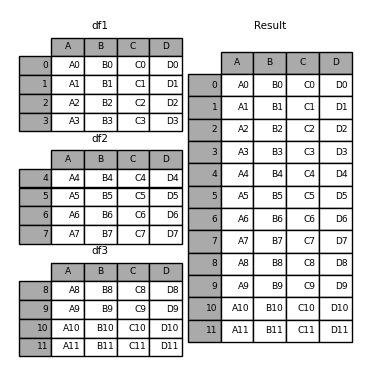

We are concatenating both the train and test datasets to identify total categorical and continuous rows

# **Feature Engineering**

In [ ]:
df = pd.concat([train[FEATURES], test[FEATURES]], axis=0)
cat_features = [col for col in FEATURES if df[col].nunique() < 25]
cont_features = [col for col in FEATURES if df[col].nunique() >= 25]

In [ ]:
cat_features

In [ ]:
print(f" Total number of rows :",df.shape[0])
print(f" Number of categorical columns :",len(cat_features))
print(f" Number of continuous columns :",len(cont_features))

In [ ]:
data = [len(cat_features),len(cont_features)]
labels = ['Categorical', 'Continuous']

x = ['Categorical', 'Continuous']
y = [len(cat_features),len(cont_features)]

colors = sns.color_palette('bright')[1:3]

plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')

In [ ]:
sns.barplot( y=data,x=labels)

In [ ]:
ncols = 5
nrows = 20
n_features = cont_features[:100]
fig, axes = plt.subplots(nrows, ncols, figsize=(25, 15*4))

for r in range(nrows):
    for c in range(ncols):
        col = n_features[r*ncols+c]
        sns.kdeplot(x=train[col], ax=axes[r, c], color='#F8766D', label='Train data' , fill =True )
        sns.kdeplot(x=test[col], ax=axes[r, c], color='#00BFC4', label='Test data', fill =True)
        axes[r,c].legend()
        axes[r, c].set_ylabel('')
        axes[r, c].set_xlabel(col, fontsize=8)
        axes[r, c].tick_params(labelsize=5, width=0.5)
        axes[r, c].xaxis.offsetText.set_fontsize(6)
        axes[r, c].yaxis.offsetText.set_fontsize(4)
plt.show()

In [ ]:
train[FEATURES]

In [ ]:
X = train.iloc[:,:-1]
y = train.iloc[:,-1:]

# **Modelling**

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=32)

In [ ]:
model = LGBMClassifier()
model.fit(X_train,y_train)

In [ ]:
y_pred=model.predict(X_test)

In [ ]:
print("Accuracy score : ",accuracy_score(y_test,y_pred))

# **Prediction**

In [ ]:
submission = pd.read_csv(r"../input/tabular-playground-series-feb-2022/sample_submission.csv")
submission.head()

In [ ]:
lgb_submission = submission.copy()
lgb_submission['target']=model.predict(test)

In [ ]:
model.predict(test)

In [ ]:
lgb_submission.to_csv(r"submission.csv",index=False)

Feature Importance of LGBMClassifiers

In [ ]:
plt.figure(figsize=(10,5))

importances = pd.Series(model.feature_importances_, index = X.columns)
importances = importances.sort_values()
importances = importances.tail(15)
importances.plot(kind = "barh")
plt.title("importance in the LGBMClassifier Model")

plt.show()

In [ ]:
label = lgb_submission.groupby('target').sum()
label = label.index

print('kind of submission target is:',len(label))

plt.figure(figsize=(8,8))
plt.pie(lgb_submission['target'].value_counts(),counterclock=False, startangle=90,labels=label,
       autopct='%1.1f%%', pctdistance=0.7)
 
plt.show()